# Заметки

Заметки

- смена дивайса
torch.device('cpu')
model.to('cpu')

- смена дивайса
how to load the gpu trained model into the cpu?
https://stackoverflow.com/questions/55511857/how-to-load-the-gpu-trained-model-into-the-cpu

  torch.load('/path/to/saved/model', map_location='cpu')

- tourch transform 
https://pytorch.org/vision/stable/generated/torchvision.transforms.Resize.html

- plt.show + tourch 
PyTorch – How to resize an image to a given size?
https://www.tutorialspoint.com/pytorch-how-to-resize-an-image-to-a-given-size

- пример сетки в pycharm
https://debuggercafe.com/pytorch-imagefolder-for-training-cnn-models/


- topk
How to get the predict probability?
https://stackoverflow.com/questions/60182984/how-to-get-the-predict-probability
import torch.nn.functional as nnf
prob = nnf.softmax(output, dim=1)
top_p, top_class = prob.topk(1, dim = 1)

- пример торча (многоклассовая)
https://yandexwebcache.net/yandbtm?fmode=inject&tm=1668717440&tld=ru&lang=en&la=1667055616&text=ImageFolder+lavels+class_to_idx&url=http%3A//patrickdeguzman.me/notebooks/byo_imageclassifier.html&l10n=ru&mime=html&sign=52b36f2c442e76d40881a6fd85c2a2ad&keyno=0

- TRANSFER LEARNING FOR COMPUTER VISION TUTORIAL (лекции взяли от сюда видимо - ДЛС)
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

- catboost + gridsearch
https://www.kaggle.com/code/tommykamaz/catboost-gridsearch/notebook

# библиотеки

In [1]:
import os
from tqdm.autonotebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time

from PIL import Image

<ipython-input-1-ddd01fa83287>:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# загрузим данные

In [2]:
DATA_DIR = "/content/drive/MyDrive/NN_develop/transfer_learning/pops_detector/dataset"
BATCH_SIZE = 4

In [3]:
ONE_IMG = "/content/drive/MyDrive/NN_develop/transfer_learning/pops_detector/all_photo/poop/10_poop.jpg"
img = Image.open(ONE_IMG)
plt.imshow(img)

FileNotFoundError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
# !unzip hymenoptera_data.zip

# Траснформации данных

In [ ]:
# Преобразование обучающих данных для расширения обучающей выборки и её нормализация
# Для валидационной (тестовой) выборки только нормализация
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(244),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(244),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
# папка с данными. Если запускаете в колабе, нужно скопировать данные к себе в директорию и примонтировать диск. Если запускаете локально -- просто скачайте данные
image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x), data_transforms[x]) for x in ['train', 'val']} # {"train":X, "val":X}, X=ImageFolder

# специальный класс для загрузки данных в виде батчей
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=2) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

In [ ]:
# notes 

temp = image_datasets['train']
temp.class_to_idx
temp.classes

['other', 'poop']

In [ ]:
dataset_sizes # notes

{'train': 61, 'val': 14}

In [ ]:
image_datasets['train'] # notes

Dataset ImageFolder
    Number of datapoints: 244
    Root location: ./hymenoptera_data/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(244, 244), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
image_datasets['train'].classes # notes

['ants', 'bees']

Размеры обучающей и валидационной выборок:

In [ ]:
print(dataset_sizes) # notes

{'train': 244, 'val': 153}


# Предпросомтр файлов

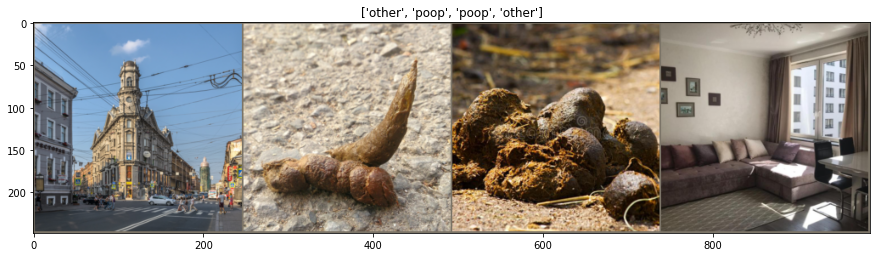

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) # меняет местами тензоры
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean # удаляем трансформацию которую сделали
    inp = np.clip(inp, 0, 1) # приводим значения от 0 до 1
    plt.figure(figsize=(15, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# Получим 1 батч (картнки-метки) из обучающей выборки
inputs, classes = next(iter(dataloaders['val'])) # test

# Расположим картинки рядом
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
inputs[0], classes[0] # notes

(tensor([[[ 1.3413,  1.4954,  1.6495,  ..., -0.3712, -0.3541, -0.3712],
          [ 1.3755,  1.5297,  1.6324,  ..., -0.3541, -0.3541, -0.3541],
          [ 1.3927,  1.5639,  1.5982,  ..., -0.3541, -0.3541, -0.3541],
          ...,
          [-1.1075, -1.1932, -1.2445,  ..., -0.4911, -0.4911, -0.5424],
          [-1.1247, -1.1932, -1.2103,  ..., -0.5596, -0.5596, -0.5767],
          [-1.1418, -1.1760, -1.2103,  ..., -0.6452, -0.5424, -0.5253]],
 
         [[ 1.7108,  1.8158,  1.9209,  ...,  0.5378,  0.5378,  0.5378],
          [ 1.7283,  1.8333,  1.9034,  ...,  0.5378,  0.5378,  0.5378],
          [ 1.7458,  1.8683,  1.8859,  ...,  0.5378,  0.5378,  0.5378],
          ...,
          [-0.9678, -1.0203, -1.0553,  ..., -0.3725, -0.3725, -0.4251],
          [-0.9678, -1.0028, -1.0203,  ..., -0.4426, -0.4426, -0.4601],
          [-0.9678, -1.0028, -1.0203,  ..., -0.5301, -0.4426, -0.4076]],
 
         [[ 2.2217,  2.3088,  2.3437,  ...,  1.5942,  1.5942,  1.6117],
          [ 2.2391,  2.3088,

In [ ]:
class_names[0] # notes

'ants'

In [ ]:
inputs[0].size() # notes

torch.Size([3, 244, 244])

(244, 244, 3)


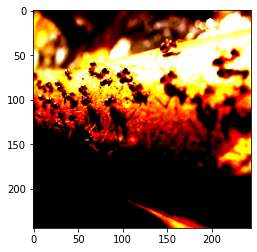

In [ ]:
# notes
# такая каптинка у чисто из тензоров
t = inputs[0].numpy().transpose((1, 2, 0)) # shape  (3, 244, 244) to (244, 244, 3)
print(t.shape)
plt.imshow(t)

## Функция вывода картинки с предсказанием

In [ ]:
def imshow_v2(inp, labels_true=None, labels_predict=None):
    """Выводит картинку с исходной меткой и предсказанной"""
    inp = inp.numpy().transpose((1, 2, 0)) # меняет местами тензоры
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean # удаляем трансформацию которую сделали
    inp = np.clip(inp, 0, 1) # приводим значения от 0 до 1
    plt.figure(figsize=(15, 12))
    plt.imshow(inp)

    title = f"True: {labels_true}, \n Predict: {labels_predict}"
    plt.title(title)
    plt.pause(0.001)

In [ ]:
# notes

for i in dataloaders['train']:
    print(i[0][0])
    break

tensor([[[-0.6109, -0.6109, -0.6109,  ..., -0.3883, -0.3883, -0.3883],
         [-0.6109, -0.6109, -0.6109,  ..., -0.3883, -0.3883, -0.3883],
         [-0.6109, -0.6109, -0.6109,  ..., -0.4054, -0.3883, -0.3883],
         ...,
         [ 0.3309,  0.2624,  0.1426,  ...,  1.3242,  1.4269,  1.4954],
         [ 0.2282,  0.1939,  0.1083,  ...,  1.3070,  1.3413,  1.3584],
         [ 0.1597,  0.1426,  0.0912,  ...,  1.2899,  1.2728,  1.2728]],

        [[ 0.1877,  0.1877,  0.1877,  ...,  0.2402,  0.2577,  0.2577],
         [ 0.1877,  0.1877,  0.1877,  ...,  0.2402,  0.2577,  0.2577],
         [ 0.1877,  0.1877,  0.1877,  ...,  0.2577,  0.2577,  0.2577],
         ...,
         [ 0.0126, -0.0399, -0.1275,  ...,  1.5007,  1.6408,  1.7283],
         [-0.0924, -0.1099, -0.1625,  ...,  1.4832,  1.5532,  1.5882],
         [-0.1625, -0.1625, -0.1800,  ...,  1.4657,  1.4832,  1.5007]],

        [[-0.5147, -0.5147, -0.5147,  ..., -0.5495, -0.5670, -0.5670],
         [-0.5147, -0.5147, -0.5147,  ..., -0

# фунеци обучения

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    #Ваш код здесь
    losses = {'train': [], "val": []}

    # по эпохам (задается выше)
    pbar = trange(num_epochs, desc="Epoch:")

    for epoch in pbar:

        # каждя эпоха имеет обучающую и тестовую стадии
        for phase in ['train', 'val']:
            if phase == 'train':
                # меняет шаг 
                scheduler.step()
                model.train(True)  # установаить модель в режим обучения
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # итерируемся по батчам
            for data in tqdm(dataloaders[phase], leave=False, desc=f"{phase} iter:"):
                # получаем картинки и метки
                inputs, labels = data

                # оборачиваем в переменные
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                else:
                    inputs, labels = inputs, labels

                # инициализируем градиенты параметров
                if phase=="train":
                    optimizer.zero_grad()

                # forward pass
                if phase == "eval":
                    with torch.no_grad():
                        outputs = model(inputs)
                else:
                    outputs = model(inputs)

                # тут даже без сотф макса просто ищет максимум?
                preds = torch.argmax(outputs, -1)
                loss = criterion(outputs, labels)

                # backward pass + оптимизируем только если это стадия обучения
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # статистика
                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            # Ваш код здесь
            losses[phase].append(epoch_loss)
            
            pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(
                                    phase, epoch_loss, epoch_acc
                                ))

            # если достиглось лучшее качество, то запомним веса модели
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model, losses

# Функция оценки точности

In [ ]:
# запускается отдельно - валид ДС в обучении не уч-ет!!!
def evaluate(model):
    model.eval()
    
    runninig_correct = 0
    for data in dataloaders['val']:
        # получаем картинки и метки
        inputs, labels = data
        
        # переносим на gpu, если возможно
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
            
        # forard pass
        output = model(inputs)
        _, predicted = torch.max(output, 1)
        
        runninig_correct += int(torch.sum(predicted == labels))
        
    return runninig_correct / dataset_sizes['val']

['other', 'poop', 'other', 'poop']

### AlexNet

In [ ]:
model = models.alexnet(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model.features[0] # notes

Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))

In [ ]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
model.classifier = nn.Linear(num_features, 2)

# Использовать ли GPU
if use_gpu:
    model = model.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# В качестве оптимизатора - стохастический градиентный спуск
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model, losses = train_model(model, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=5)

Epoch::   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train iter::   0%|          | 0/16 [00:00<?, ?it/s]

Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, b

KeyboardInterrupt: ignored

## Визуализация

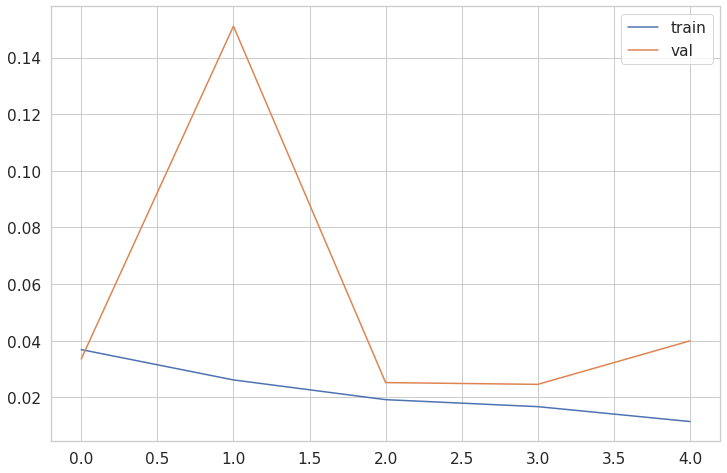

In [ ]:
# качество тупо визуализация список

import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)

# Построим график лосса при обучении и валидации

#Ваш код здесь
plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.legend()
plt.show()

# Сохранение весов модели

In [ ]:
# torch.save(model.state_dict(), 'AlexNet_fine_tune.pth')

In [ ]:
# model.load_state_dict(torch.load('AlexNet_fine_tune.pth'))

<All keys matched successfully>

In [ ]:
print("Accuracy: {0:.4f}".format(evaluate(model)))

Accuracy: 0.9286


# Заморозка слоев

In [ ]:
model_extractor = models.alexnet(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Помним, что по-умолчанию все слои нейросети обучаются заново:

In [ ]:
# notes

for param in model_extractor.parameters():
    print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


Сделаем так, чтобы на них *не распространялся backpropagation* (заморозим их), и подменим классификатор (ведь старый уже с весами для ImageNet'а).

In [ ]:
# notes

model_extractor.parameters()

<generator object Module.parameters at 0x7fc2a20d1cd0>

In [ ]:
# notes

# замораживаем параметры (веса)
for param in model_extractor.parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
model_extractor.classifier = nn.Linear(num_features, 2)

for param in model_extractor.parameters():
    print(param.requires_grad)
    # print(param)

False
False
False
False
False
False
False
False
False
False
True
True


In [ ]:
# замораживаем параметры (веса)
for param in model_extractor.parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
model_extractor.classifier = nn.Linear(num_features, 2)

# Использовать ли GPU
if use_gpu:
    model_extractor = model_extractor.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем только классификатор
optimizer = optim.Adam(model_extractor.classifier.parameters(), lr=1e-4)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
%%time
model_extractor,losses = train_model(model_extractor, loss_fn, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch::   0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train iter::   0%|          | 0/16 [00:00<?, ?it/s]

val iter::   0%|          | 0/4 [00:00<?, ?it/s]

train iter::   0%|          | 0/16 [00:00<?, ?it/s]

val iter::   0%|          | 0/4 [00:00<?, ?it/s]

train iter::   0%|          | 0/16 [00:00<?, ?it/s]

val iter::   0%|          | 0/4 [00:00<?, ?it/s]

train iter::   0%|          | 0/16 [00:00<?, ?it/s]

val iter::   0%|          | 0/4 [00:00<?, ?it/s]

train iter::   0%|          | 0/16 [00:00<?, ?it/s]

val iter::   0%|          | 0/4 [00:00<?, ?it/s]

train iter::   0%|          | 0/16 [00:00<?, ?it/s]

val iter::   0%|          | 0/4 [00:00<?, ?it/s]

train iter::   0%|          | 0/16 [00:00<?, ?it/s]

val iter::   0%|          | 0/4 [00:00<?, ?it/s]

train iter::   0%|          | 0/16 [00:00<?, ?it/s]

val iter::   0%|          | 0/4 [00:00<?, ?it/s]

train iter::   0%|          | 0/16 [00:00<?, ?it/s]

val iter::   0%|          | 0/4 [00:00<?, ?it/s]

train iter::   0%|          | 0/16 [00:00<?, ?it/s]

val iter::   0%|          | 0/4 [00:00<?, ?it/s]

train iter::   0%|          | 0/16 [00:00<?, ?it/s]

val iter::   0%|          | 0/4 [00:00<?, ?it/s]

train iter::   0%|          | 0/16 [00:00<?, ?it/s]

val iter::   0%|          | 0/4 [00:00<?, ?it/s]

train iter::   0%|          | 0/16 [00:00<?, ?it/s]

val iter::   0%|          | 0/4 [00:00<?, ?it/s]

train iter::   0%|          | 0/16 [00:00<?, ?it/s]

val iter::   0%|          | 0/4 [00:00<?, ?it/s]

train iter::   0%|          | 0/16 [00:00<?, ?it/s]

val iter::   0%|          | 0/4 [00:00<?, ?it/s]

train iter::   0%|          | 0/16 [00:00<?, ?it/s]

val iter::   0%|          | 0/4 [00:00<?, ?it/s]

train iter::   0%|          | 0/16 [00:00<?, ?it/s]

val iter::   0%|          | 0/4 [00:00<?, ?it/s]

train iter::   0%|          | 0/16 [00:00<?, ?it/s]

val iter::   0%|          | 0/4 [00:00<?, ?it/s]

train iter::   0%|          | 0/16 [00:00<?, ?it/s]

val iter::   0%|          | 0/4 [00:00<?, ?it/s]

train iter::   0%|          | 0/16 [00:00<?, ?it/s]

val iter::   0%|          | 0/4 [00:00<?, ?it/s]

train iter::   0%|          | 0/16 [00:00<?, ?it/s]

val iter::   0%|          | 0/4 [00:00<?, ?it/s]

train iter::   0%|          | 0/16 [00:00<?, ?it/s]

val iter::   0%|          | 0/4 [00:00<?, ?it/s]

train iter::   0%|          | 0/16 [00:00<?, ?it/s]

val iter::   0%|          | 0/4 [00:00<?, ?it/s]

train iter::   0%|          | 0/16 [00:00<?, ?it/s]

val iter::   0%|          | 0/4 [00:00<?, ?it/s]

train iter::   0%|          | 0/16 [00:00<?, ?it/s]

val iter::   0%|          | 0/4 [00:00<?, ?it/s]

Training complete in 1m 44s
Best val Acc: 0.928571
CPU times: user 7.53 s, sys: 4.99 s, total: 12.5 s
Wall time: 1min 43s


In [ ]:
# torch.save(model_extractor.state_dict(), 'AlexNet_extractor.pth')

In [ ]:
# model_extractor.load_state_dict(torch.load('AlexNet_extractor.pth'))

<All keys matched successfully>

In [ ]:
print("Accuracy: {0:.4f}".format(evaluate(model_extractor)))

Accuracy: 0.9286


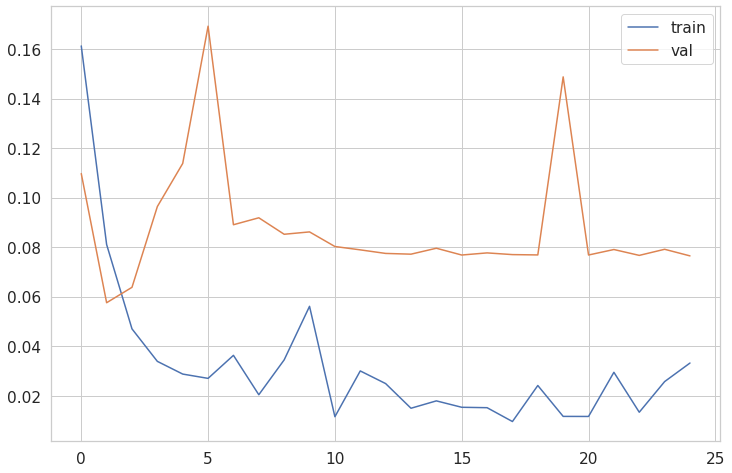

In [ ]:
# качество тупо визуализация список

import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)

# Построим график лосса при обучении и валидации

#Ваш код здесь
plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.legend()
plt.show()

In [ ]:
TORCH_FILE_NAME = './AlexNet_fine_tune.pth'

# Save:
torch.save(model_extractor.state_dict(), TORCH_FILE_NAME)

In [ ]:
# Load:
model_test = models.alexnet(pretrained=False)
model_test.classifier = nn.Linear(num_features, 2)
model_test.load_state_dict(torch.load(TORCH_FILE_NAME))
# model.eval()

<All keys matched successfully>

# Вывод изображения с рисованием меток

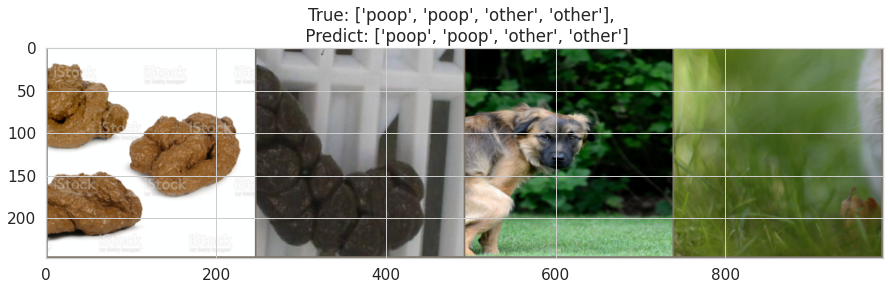

In [ ]:
# Получим 1 батч (картнки-метки) из обучающей выборки
# выплевывает 4 картинки - 1 батч
inputs, labels = next(iter(dataloaders['train'])) # val

# Расположим картинки рядом
out = torchvision.utils.make_grid(inputs)

# предсказание
# переведем модель на cpu
model_extractor.to('cpu')
# модель в режим предсказания
model_extractor.eval()

with torch.no_grad():
  # сделаем предсказание и возьмем софтмакс
  output = model_extractor(inputs)
  _, predicted = torch.max(output, 1)

# сгенерим списки мето
labels_true = [class_names[x] for x in predicted]
labels_predict = [class_names[x] for x in labels]
# вызовем нашу функцию с картинками
imshow_v2(out, labels_true, labels_predict)

# Предсказание одного файла

In [ ]:
img = Image.open(ONE_IMG)
# plt.imshow(img)
  
transformed_img = data_transforms["val"](img)
transformed_img.size()

with torch.no_grad():
    model_extractor.eval()
    logit = model_extractor(transformed_img.unsqueeze(0))
    probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    id = np.argmax(probs)
    predicted_class = class_names[id]
    print(predicted_class)

# Предсказание для файла по ссылке

(1440, 1080)


Text(0.5, 1.0, 'loaded img')

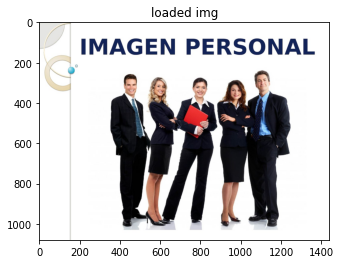

In [ ]:
from PIL import Image
import requests
from io import BytesIO

URL = "https://wallbox.ru/resize/800x480/wallpapers/main/201150/priroda-6d3c0aa0b709.jpg"
URL = "https://p.calameoassets.com/160810152536-3dbd84e9398a3a4ccc1ad50cb4651692/p1.jpg"

response = requests.get(URL)
img_inernet = Image.open(BytesIO(response.content))
print(img_inernet.size)
plt.imshow(img_inernet)
plt.title("loaded img")



In [ ]:
URL = "https://proproprogs.ru/django/drf-ustanovka-django-rest-framework"
URL = "https://p.calameoassets.com/160810152536-3dbd84e9398a3a4ccc1ad50cb4651692/p1.jpg"
response = requests.get(URL)

try:
  im = Image.open(BytesIO(response.content))
  im.verify() #I perform also verify, don't know if he sees other types o defects
  im.close() #reload is necessary in my case
except: 
  print('smth')

In [ ]:
URL.rsplit('/', 1)[1].rsplit('.', 1)[1]

'jpg'

(1440, 1080)
torch.Size([3, 244, 244])


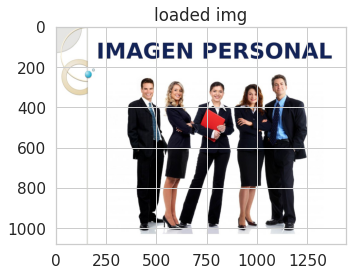

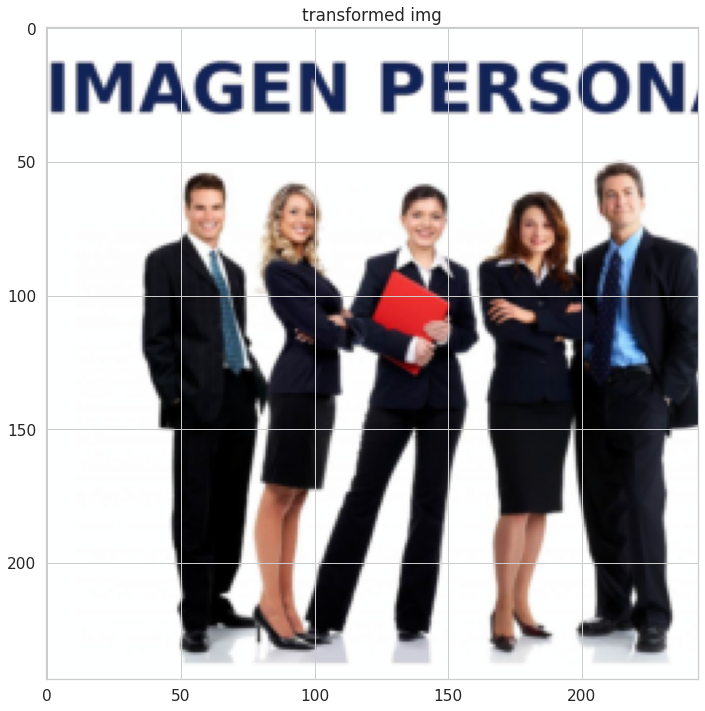

[[0.9988483 0.0011517]]
0
other


In [ ]:
from PIL import Image
import requests
from io import BytesIO

URL = "https://wallbox.ru/resize/800x480/wallpapers/main/201150/priroda-6d3c0aa0b709.jpg"
URL = "https://p.calameoassets.com/160810152536-3dbd84e9398a3a4ccc1ad50cb4651692/p1.jpg"

response = requests.get(URL)
img_inernet = Image.open(BytesIO(response.content))
print(img_inernet.size)
plt.imshow(img_inernet)
plt.title("loaded img")

transformed_img = data_transforms["val"](img_inernet)
print(transformed_img.size())
imshow(transformed_img, title = "transformed img")


with torch.no_grad():
    model_extractor.eval()
    logit = model_extractor(transformed_img.unsqueeze(0))
    probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    print(probs)
    id = np.argmax(probs)
    print(id)
    predicted_class = class_names[id]
    print(predicted_class)

poop


# Замрорзка нескольких слоев

In [ ]:
model_mixed = models.alexnet(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# notes

layers_to_unfreeze = 5

# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in model_mixed.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False
    
for param in model_mixed.parameters():
    print(param.requires_grad)
    # print(param)

False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True


In [ ]:
layers_to_unfreeze = 5

# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in model_mixed.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False
    
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
model_mixed.classifier = nn.Linear(num_features, 2)

# Использовать ли GPU
if use_gpu:
    model_mixed = model_mixed.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем последние layers_to_unfreeze слоев из сверточной части и fully connected слой 
# parameters() возвращает просто список тензоров парамтеров, поэтому два таких списка можно сложить
# optimizer = optim.Adam(list(model_mixed.features.parameters())[-layers_to_unfreeze:] + 
#                       list(model_mixed.classifier.parameters()), lr=1e-4)
optimizer = optim.Adam(model_mixed.classifier.parameters(), lr=1e-4)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
%%time
_, losses = train_model(model_mixed, loss_fn, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch::   0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train iter::   0%|          | 0/16 [00:00<?, ?it/s]

val iter::   0%|          | 0/4 [00:00<?, ?it/s]

train iter::   0%|          | 0/16 [00:00<?, ?it/s]

val iter::   0%|          | 0/4 [00:00<?, ?it/s]

train iter::   0%|          | 0/16 [00:00<?, ?it/s]

val iter::   0%|          | 0/4 [00:00<?, ?it/s]

train iter::   0%|          | 0/16 [00:00<?, ?it/s]

val iter::   0%|          | 0/4 [00:00<?, ?it/s]

train iter::   0%|          | 0/16 [00:00<?, ?it/s]

val iter::   0%|          | 0/4 [00:00<?, ?it/s]

train iter::   0%|          | 0/16 [00:00<?, ?it/s]

val iter::   0%|          | 0/4 [00:00<?, ?it/s]

train iter::   0%|          | 0/16 [00:00<?, ?it/s]

val iter::   0%|          | 0/4 [00:00<?, ?it/s]

train iter::   0%|          | 0/16 [00:00<?, ?it/s]

val iter::   0%|          | 0/4 [00:00<?, ?it/s]

train iter::   0%|          | 0/16 [00:00<?, ?it/s]

val iter::   0%|          | 0/4 [00:00<?, ?it/s]

train iter::   0%|          | 0/16 [00:00<?, ?it/s]

val iter::   0%|          | 0/4 [00:00<?, ?it/s]

train iter::   0%|          | 0/16 [00:00<?, ?it/s]

val iter::   0%|          | 0/4 [00:00<?, ?it/s]

train iter::   0%|          | 0/16 [00:00<?, ?it/s]

val iter::   0%|          | 0/4 [00:00<?, ?it/s]

train iter::   0%|          | 0/16 [00:00<?, ?it/s]

val iter::   0%|          | 0/4 [00:00<?, ?it/s]

train iter::   0%|          | 0/16 [00:00<?, ?it/s]

val iter::   0%|          | 0/4 [00:00<?, ?it/s]

train iter::   0%|          | 0/16 [00:00<?, ?it/s]

val iter::   0%|          | 0/4 [00:00<?, ?it/s]

train iter::   0%|          | 0/16 [00:00<?, ?it/s]

val iter::   0%|          | 0/4 [00:00<?, ?it/s]

train iter::   0%|          | 0/16 [00:00<?, ?it/s]

val iter::   0%|          | 0/4 [00:00<?, ?it/s]

train iter::   0%|          | 0/16 [00:00<?, ?it/s]

val iter::   0%|          | 0/4 [00:00<?, ?it/s]

train iter::   0%|          | 0/16 [00:00<?, ?it/s]

val iter::   0%|          | 0/4 [00:00<?, ?it/s]

train iter::   0%|          | 0/16 [00:00<?, ?it/s]

val iter::   0%|          | 0/4 [00:00<?, ?it/s]

train iter::   0%|          | 0/16 [00:00<?, ?it/s]

val iter::   0%|          | 0/4 [00:00<?, ?it/s]

train iter::   0%|          | 0/16 [00:00<?, ?it/s]

val iter::   0%|          | 0/4 [00:00<?, ?it/s]

train iter::   0%|          | 0/16 [00:00<?, ?it/s]

val iter::   0%|          | 0/4 [00:00<?, ?it/s]

train iter::   0%|          | 0/16 [00:00<?, ?it/s]

val iter::   0%|          | 0/4 [00:00<?, ?it/s]

train iter::   0%|          | 0/16 [00:00<?, ?it/s]

val iter::   0%|          | 0/4 [00:00<?, ?it/s]

Training complete in 1m 23s
Best val Acc: 0.928571
CPU times: user 7.03 s, sys: 5.38 s, total: 12.4 s
Wall time: 1min 22s


In [ ]:
torch.save(model_mixed.state_dict(), 'AlexNet_mixed.pth')

In [ ]:
model_mixed.load_state_dict(torch.load('AlexNet_mixed.pth'))

<All keys matched successfully>

In [ ]:
print("Accuracy: {0:.4f}".format(evaluate(model_mixed)))

Accuracy: 0.9286


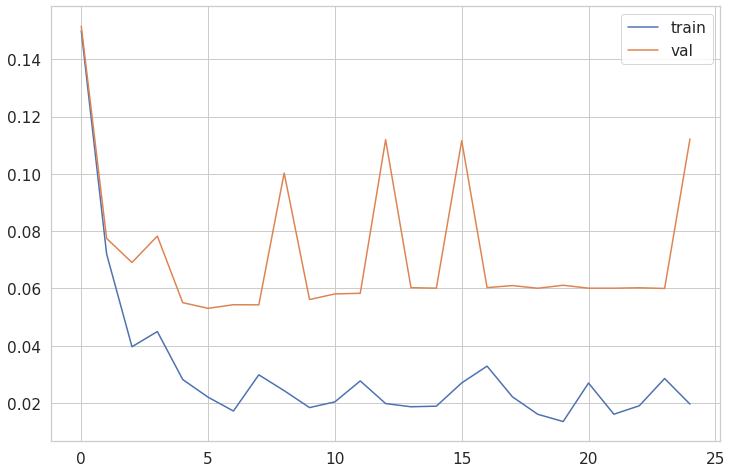

In [ ]:
# качество тупо визуализация список

import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)

# Построим график лосса при обучении и валидации

#Ваш код здесь
plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.legend()
plt.show()

## Еще один метод

Можно не замораживать все первые слои, а делать так, чтобы шаг градиента на них был меньше. Интерфейс оптимизатора позволяет это делать.

In [ ]:
model_diff_lr = models.alexnet(pretrained=True)

model_diff_lr.classifier = nn.Linear(num_features, 2)

optimizer = torch.optim.Adam(params=[
        {"params": model_diff_lr.classifier.parameters()},
        {"params": model_diff_lr.features.parameters(), "lr": 1e-5,}
    ], 
    lr=1e-4
)

criterion = nn.CrossEntropyLoss()


# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

NameError: ignored

In [ ]:
model_diff_lr.to("cuda")

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Linear(in_features=9216, out_features=2, bias=True)
)

In [ ]:
_, losses = train_model(model_diff_lr, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)



Training complete in 1m 30s
Best val Acc: 0.947712


In [ ]:
print("Accuracy: {0:.4f}".format(evaluate(model_diff_lr)))

NameError: ignored

# ЗАМЕТКИ

In [ ]:
# # notes 

# import torch
# from torchvision import transforms

# p = transforms.Compose([
#         transforms.Resize(size=256, max_size=300), # can youple (256, 256) but propotion will be losted
#         transforms.CenterCrop(244), # делает черные полосы по сторонам если не влезает
#         # transforms.ToTensor(),
#         # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ])

# ONE_FILE = "/content/drive/MyDrive/NN_develop/transfer_learning/pops_detector/all_photo/other/10_dog.jpg"
# from PIL import Image

# img = Image.open(ONE_FILE)
# img_resized = p(img)
# img

# print(img_resized.size)
# plt.imshow(img_resized)
# plt.show()
# plt.imshow(img_resized)
# plt.show()